# Damages from extreme heat at the subnational level
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import stats

Data locations

In [2]:
loc_damages = "../Data/Damages/"
loc_shp = "../Data/Shapefile/"
loc_panel = "../Data/Panel/"
loc_emissions = "../Data/Emissions/"

Years

In [3]:
y1 = 1993
y2 = 2013
yrs = np.arange(y1,y2+1,1)
nyrs = len(yrs)

Get shapefile

In [4]:
shp = gp.read_file(loc_shp+"gadm36_1.shp")
shp = shp.rename(columns={"GID_1":"region"})

#### Analysis

Read damages

In [5]:
extr = "tx5d"
smooth_len = 15
damages_tx = xr.open_dataset(loc_damages+"CMIP6_historical_region_"+extr+"_income_damages_smooth"+str(smooth_len)+"_"+str(y1)+"-"+str(y2)+".nc")
obs_gpc = damages_tx.obs_gpc_mean
yr_gpc = 2010
obs_gpc_yr = obs_gpc.loc[:,yr_gpc]
obs_gdp_yr = damages_tx.obs_gdp_mean.loc[:,yr_gpc]

In [6]:
x = damages_tx.gdp_change_mean.sum(dim="time")

In [7]:
snr_tx = np.abs(damages_tx.gpc_change_pct_mean)/damages_tx.gpc_change_pct_std
snr_mean = snr_tx.mean(dim="time")

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Calculate country-level damages

In [8]:
iso_region = xr.DataArray([str(x)[0:3] for x in damages_tx.region.values],
                         coords=[damages_tx.region.values],dims=["region"])
damages_tx.coords["iso"] = iso_region
damages_tx_country = damages_tx.gpc_change_pct_mean.groupby("iso").mean()
obs_gpc_yr.coords["iso"] = iso_region
obs_gpc_iso = obs_gpc_yr.groupby("iso").mean()
damages_tx_country_sum = damages_tx.gdp_change_mean.groupby("iso").sum()

Read emissions

In [9]:
emissions_in = xr.open_dataarray(loc_emissions+"FAIR_Emissions_Input_Territorial_1990-2014.nc")
co2_emissions = emissions_in.loc[:,y1:y2,["CO2-fossil"]].sum(dim=["species"])*1e9
cumul_emissions = co2_emissions.sum(dim="time")

In [10]:
iso_final = [x for x in damages_tx_country.iso.values if x in cumul_emissions.iso.values]

GPC percentiles

In [11]:
gpc_pctiles = np.array([stats.percentileofscore(obs_gpc_iso.loc[iso_final].values,x) for x in obs_gpc_iso.loc[iso_final].values])

Emissions anomaly

In [12]:
cumul_emissions2 = cumul_emissions.where(cumul_emissions!=0,np.nan)
emissions_centered = np.log(cumul_emissions2) - np.mean(np.log(cumul_emissions2))

In [13]:
x_1 = emissions_centered.loc[iso_final]
x = x_1.values
y_1 = damages_tx_country.mean(dim="time").loc[iso_final]
y = y_1.values

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


LinregressResult(slope=0.5504736176116128, intercept=-4.416658136488912, rvalue=0.5174420374494488, pvalue=3.408491912988682e-10, stderr=0.08077997964055322)


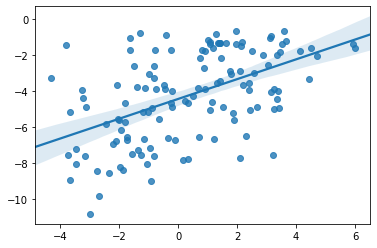

In [14]:
x = emissions_centered.loc[iso_final].values
y = damages_tx_country.mean(dim="time").loc[iso_final].values
ind = (~np.isnan(x))&(~np.isnan(y))&(x>-8)
print(stats.linregress(x[ind],y[ind]))
sns.regplot(x[ind],y[ind])

In [15]:
np.nanmean(y[gpc_pctiles<=10])

-6.999578967568548

In [16]:
np.nanmean(y[gpc_pctiles>=90])

-1.6706111195072118

Plot!

decile means
0
-6.716124140095814
1
-5.629856879638604
2
-4.762485650610216
3
-4.012749029283785
4
-4.376843406458804
5
-3.968302101819129
6
-2.9376691905556873
7
-3.454120793048687
8
-2.5626023229962747
9
-1.4852534426424102


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


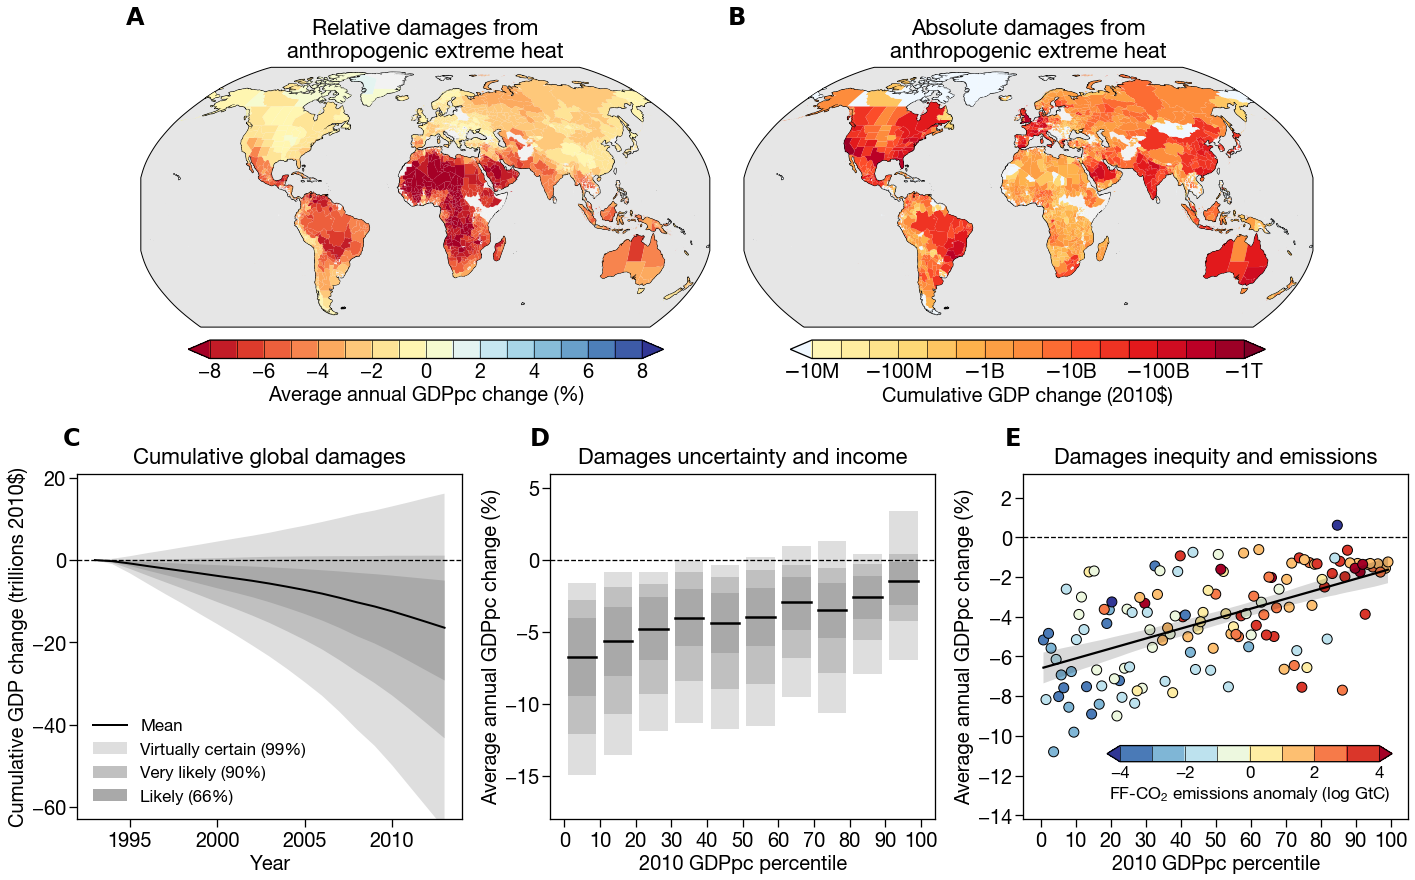

In [18]:
fig = plt.figure(figsize=(22,16))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

tfs = 22

## maps on top
gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.16,right=0.9,top=0.9,bottom=0.62,wspace=0.06,hspace=0.3)

for k in [0,1]:
    ax = plt.subplot(gs1[0,k],projection=ccrs.Robinson())
    ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])
    ax.add_feature(cart.feature.LAND, edgecolor="black",facecolor=[0.98,0.98,0.98])

    
    if k == 0:
        
        # set colors
        vals = damages_tx.gpc_change_pct_mean.mean(dim="time")
        vmin = -8
        vmax = 8
        ncol = 17
        cmapname = 'RdYlBu'

        bounds = np.linspace(vmin,vmax,ncol)
        cols = plt.get_cmap(cmapname)(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-1])
        cm.set_over(cols[-1])
        cm.set_under(cols[0])
        norm = colors.Normalize(vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)
        
        tks = np.arange(-8,8+2,2)

    else:
        gdp_change_plot = damages_tx.gdp_change_mean.sum(dim="time")
        vals = gdp_change_plot.where(gdp_change_plot!=0,np.nan)

        vmin = 1e7
        vmax = 1e12
        ncol = 16
        bounds = np.linspace(vmin,vmax,ncol)

        cols = plt.get_cmap('YlOrRd')(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-1])
        cm.set_over(cols[-1])
        #cm.set_under(cols[0])
        cm.set_under("aliceblue")
        norm = colors.SymLogNorm(linthresh=1e3,vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)
        
        lbs = [r"$\rm{-}$10M",r"$\rm{-}$100M",r"$\rm{-}$1B",\
               r"$\rm{-}$10B",r"$\rm{-}$100B",r"$\rm{-}$1T"]
        #lbs = ["100M","1B","10B","100B","1T"]
        tks = [1e7,1e8,1e9,1e10,1e11,1e12]

        
    
    # add geometries
    
    baseline_col = [0.95,0.95,0.95]
    for i in shp.region:
        geom = shp.loc[shp.region==i,"geometry"]
        if i in vals.region.values:
            if k == 0:
                val = vals.loc[i].values
            elif k == 1:
                # if loss is greater than -100M, plot
                # otherwise make it blue
                val1 = vals.loc[i].values
                if (~np.isnan(val))&(val1 < -1e8):
                    val = np.abs(val1)
                elif (~np.isnan(val))&(val >= -1e8):
                    val = -10
                else:
                    val = np.nan
                    
            col = cbar.to_rgba(val)
            snr = 0.0
            h = ""
            #snr = snr_mean.loc[i].values

            if (~np.isnan(val)) & (snr>1):
                ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                                      edgecolor="black",linewidth=0,zorder=10)
            elif (~np.isnan(val)) & (snr<=1):
                ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                                      edgecolor="black",linewidth=0,zorder=10,
                                     hatch=h)
            else:
                ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=baseline_col,
                                      edgecolor="black",linewidth=0)
        else:
            ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=baseline_col,
                                      edgecolor="black",linewidth=0)
    
    
    if k == 0:
        plt.title("Relative damages from"+"\n"+"anthropogenic extreme heat",pad=10,fontsize=tfs)
        l = 0.19
    else:
        plt.title("Absolute damages from"+"\n"+"anthropogenic extreme heat",pad=10,fontsize=tfs)
        l = 0.57
    b = 0.62
    w = 0.3
    h = 0.016
    cbar_ax = fig.add_axes([l,b,w,h])
    cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                                  drawedges=True,extend="both",
                     ticks=tks)
    cbar_ax.tick_params(direction="in",width=0.05)
    if k == 0:
        cb.set_label("Average annual GDPpc change (%)")
    if k == 1:
        cb.ax.set_xticklabels(lbs)
        cb.set_label("Cumulative GDP change (2010$)")


        

## plots below the map
gs2 = gridspec.GridSpec(1,3)
gs2.update(left=0.12,right=0.96,top=0.52,bottom=0.22,wspace=0.23,hspace=0.3)


# cumulative effect
ax = plt.subplot(gs2[0,0])

plotcol = "royalblue"
scaling = 1e12

mn = damages_tx.gdp_change_cumulative_all_mean
qs = damages_tx.gdp_change_cumulative_all_quantiles
    
plt.plot(yrs,mn/scaling,
        color="black",linewidth=2,label="Mean")
ax.fill_between(yrs,qs.loc[0.005,:]/scaling,qs.loc[0.995,:]/scaling,
               facecolor="lightgray",alpha=0.75,label="Virtually certain (99%)")
ax.fill_between(yrs,qs.loc[0.05,:]/scaling,qs.loc[0.95,:]/scaling,
               facecolor="silver",alpha=1,label="Very likely (90%)")
ax.fill_between(yrs,qs.loc[0.17,:]/scaling,qs.loc[0.83,:]/scaling,
               facecolor="darkgrey",alpha=1,label="Likely (66%)")

plt.axhline(y=0,linewidth=1.3,color="black",linestyle="--")
plt.xlabel("Year")
plt.ylabel("Cumulative GDP change (trillions 2010$)")
plt.legend(loc="lower left",fontsize=17,frameon=False)
plt.title("Cumulative global damages",fontsize=tfs,pad=10)
#plt.yticks([-3,-2,-1,0])
plt.ylim([-63,21])


# uncertainty across income deciles
ax = plt.subplot(gs2[0,1])

plt.axhline(y=0,color="black",linestyle="--",linewidth=1.3)

damages_deciles = damages_tx.gpc_change_pct_mean_decile
deciles = damages_deciles.decile.values
print("decile means")
for d in deciles:
    mean = damages_deciles.sel(decile=d).mean(dim="uncertainty")
    print(d)
    print(mean.values)
    wd = 0.4
    xs = [d+1-wd,d+1+wd]
    plt.plot(xs,[mean,mean],color="black",linewidth=2.5)
    ax.fill_between(xs,damages_deciles.sel(decile=d).quantile(0.005,dim="uncertainty"),
                   damages_deciles.sel(decile=d).quantile(0.995,dim="uncertainty"),
                   facecolor="lightgray",alpha=0.75)
    ax.fill_between(xs,damages_deciles.sel(decile=d).quantile(0.05,dim="uncertainty"),
                   damages_deciles.sel(decile=d).quantile(0.95,dim="uncertainty"),
                   facecolor="silver",alpha=1)
    ax.fill_between(xs,damages_deciles.sel(decile=d).quantile(0.17,dim="uncertainty"),
                   damages_deciles.sel(decile=d).quantile(0.83,dim="uncertainty"),
                   facecolor="darkgrey",alpha=1)

plt.xticks(ticks=np.arange(0.5,10.5+1,1),labels=["0","10","20","30","40","50","60","70","80","90","100"])
plt.xlabel("2010 GDPpc percentile")
plt.ylabel("Average annual GDPpc change (%)")
plt.title("Damages uncertainty and income",fontsize=tfs,pad=10)
plt.ylim([-18,6])
plt.yticks([-15,-10,-5,0,5])



# scatter
ax = plt.subplot(gs2[0,2])


# emissions colorbar
vmin = -4
vmax = 4
ncol = 9
bounds = np.linspace(vmin,vmax,ncol)

cols = plt.get_cmap('RdYlBu_r')(np.linspace(0,1,len(bounds)+1))
cm = colors.ListedColormap(cols[1:-1])
cm.set_over(cols[-1])
cm.set_under(cols[0])
norm = colors.Normalize(vmin=vmin,vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)

# scatter
#iso_final = [x for x in damages_tx_only_country.iso.values if (x in cumul_emissions.iso.values)&(x in obs_gpc_yr.iso.values)]
x = gpc_pctiles*1.0
y = damages_tx_country.mean(dim="time").loc[iso_final].values
ind = (~np.isnan(x))&(~np.isnan(y))
cols = [cbar.to_rgba(emissions_centered.loc[i].values) for i in iso_final]

plt.scatter(x,y,s=100,facecolor=cols,edgecolor="black")
sns.regplot(x,y,scatter=False,truncate=True,color="black")

plt.axhline(y=0,linewidth=1.3,color="black",linestyle="--")

plt.title("Damages inequity and emissions",fontsize=tfs,pad=10)
plt.xlabel("2010 GDPpc percentile")
plt.ylabel("Average annual GDPpc change (%)")
plt.ylim([-14.2,3.2])
plt.yticks([-14,-12,-10,-8,-6,-4,-2,0,2])
plt.xlim([-5,105])
plt.xticks(np.arange(0,100+1,10))
#plt.text(80,-0.46,r"$\it{P}$ < 0.001",fontsize=18)

l = 0.77
b = 0.27
w = 0.18
h = 0.014
cbar_ax = fig.add_axes([l,b,w,h])
cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                              drawedges=True,extend="both")
cbar_ax.tick_params(direction="in",width=0.05,labelsize=17)
cb.set_label("FF-CO$_2$ emissions anomaly (log GtC)",fontsize=17)
#cb.set_label("FF-CO$_2$ emissions anomaly (log GtC)",
#            rotation=270,labelpad=30)




plt.figtext(0.15,0.91,r"$\bf{A}$",fontsize=24)
plt.figtext(0.53,0.91,r"$\bf{B}$",fontsize=24)
plt.figtext(0.11,0.545,r"$\bf{C}$",fontsize=24)
plt.figtext(0.405,0.545,r"$\bf{D}$",fontsize=24)
plt.figtext(0.705,0.545,r"$\bf{E}$",fontsize=24)


plt.savefig("../Figures/Fig4.png",dpi=600)
plt.show()

In [19]:
mc_pct_negative = damages_tx.gpc_change_mc_pct_negative[~np.isnan(damages_tx.gpc_change_pct_mean.mean(dim="time"))]
mc_pct_positive = damages_tx.gpc_change_mc_pct_positive[~np.isnan(damages_tx.gpc_change_pct_mean.mean(dim="time"))]

In [20]:
ndamage = len(mc_pct_negative.values)

In [21]:
print(len(mc_pct_negative[mc_pct_negative>0.6])/ndamage)
print(len(mc_pct_negative[mc_pct_negative>0.7])/ndamage)
print(len(mc_pct_negative[mc_pct_negative>0.75])/ndamage)
print(len(mc_pct_negative[mc_pct_negative>0.8])/ndamage)
print(len(mc_pct_negative[mc_pct_negative>0.9])/ndamage)
print(len(mc_pct_negative[mc_pct_negative>0.99])/ndamage)

0.9470734744707348
0.8374844333748444
0.7727272727272727
0.7085927770859277
0.5859277708592777
0.31320049813200496


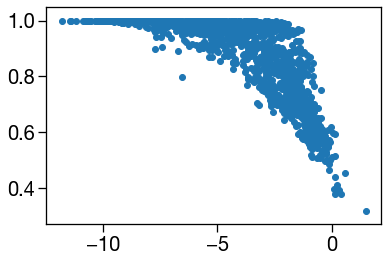

In [22]:
ind = ~np.isnan(damages_tx.gpc_change_pct_mean.mean(dim="time"))
plt.scatter(damages_tx.gpc_change_pct_mean.mean(dim="time")[ind],mc_pct_negative)

In [23]:
damages_tx.gdp_change_cumulative_all_mean

<xarray.DataArray 'gdp_change_cumulative_all_mean' (time: 21)>
array([ 0.000000e+00, -2.623224e+11, -8.188360e+11, -1.442987e+12,
       -2.036705e+12, -2.621222e+12, -3.221108e+12, -3.832680e+12,
       -4.422120e+12, -5.029665e+12, -5.712912e+12, -6.470195e+12,
       -7.270054e+12, -8.147495e+12, -9.161896e+12, -1.026512e+13,
       -1.127065e+13, -1.244648e+13, -1.373986e+13, -1.507838e+13,
       -1.643931e+13])
Coordinates:
  * time     (time) int64 1993 1994 1995 1996 1997 ... 2009 2010 2011 2012 2013

In [24]:
damages_tx.gdp_change_cumulative_all_quantiles.loc[[0.005,0.995],2013]/1e12

<xarray.DataArray 'gdp_change_cumulative_all_quantiles' (quantile: 2)>
array([-65.29205728,  16.15005643])
Coordinates:
    time      int64 2013
  * quantile  (quantile) float64 0.005 0.995

In [25]:
damages_tx.gdp_change_cumulative_all_quantiles.loc[[0.05,0.95],2013]/1e12

<xarray.DataArray 'gdp_change_cumulative_all_quantiles' (quantile: 2)>
array([-43.30934064,   1.08489999])
Coordinates:
    time      int64 2013
  * quantile  (quantile) float64 0.05 0.95

In [26]:
50+(66/2.0)

83.0

In [27]:
50-(66/2.0)

17.0

In [28]:
damages_tx.gdp_change_cumulative_all_quantiles.loc[[0.17,0.83],2013]/1e12

<xarray.DataArray 'gdp_change_cumulative_all_quantiles' (quantile: 2)>
array([-29.25185111,  -4.98080908])
Coordinates:
    time      int64 2013
  * quantile  (quantile) float64 0.17 0.83

In [29]:
damages_tx.gpc_change_pct_mean[["BRA" in x for x in damages_tx.region.values],:].mean(dim="time")

<xarray.DataArray 'gpc_change_pct_mean' (region: 27)>
array([-4.4554436 , -7.75206742, -6.91028276, -5.39648901, -5.03971663,
       -4.34606405, -4.78771847, -4.29724833, -4.9035939 , -4.20544047,
       -5.5132075 , -4.34536658, -2.87580501, -5.67968416, -5.90674498,
       -3.74059947, -4.44544297, -3.92926554, -6.5139647 , -4.36388098,
       -4.80877109, -5.58341646, -4.12641797, -4.3811429 ,         nan,
       -4.43108311, -7.2088362 ])
Coordinates:
  * region   (region) object 'BRA.10_1' 'BRA.11_1' ... 'BRA.8_1' 'BRA.9_1'
    iso      (region) <U3 'BRA' 'BRA' 'BRA' 'BRA' ... 'BRA' 'BRA' 'BRA' 'BRA'

In [30]:
damages_tx.gpc_change_pct_mean[["VEN" in x for x in damages_tx.region.values],:].mean(dim="time")

<xarray.DataArray 'gpc_change_pct_mean' (region: 24)>
array([        nan, -5.51827664, -7.68536677, -6.66554064, -3.8766844 ,
       -6.09870661, -7.28595885,         nan, -7.1156616 , -6.0154162 ,
       -4.59146758, -5.59370368, -5.04216418,         nan, -6.41140979,
       -7.4417025 , -7.59072575, -8.32885544, -5.86382331, -6.92943359,
       -7.0270097 ,         nan, -7.95452307, -6.10760314])
Coordinates:
  * region   (region) object 'VEN.10_1' 'VEN.12_1' ... 'VEN.8_1' 'VEN.9_1'
    iso      (region) <U3 'VEN' 'VEN' 'VEN' 'VEN' ... 'VEN' 'VEN' 'VEN' 'VEN'

In [31]:
damages_tx.gpc_change_pct_mean[["MLI" in x for x in damages_tx.region.values],:].mean(dim="time")

<xarray.DataArray 'gpc_change_pct_mean' (region: 8)>
array([ -8.51224832, -10.8843447 , -10.23473993, -10.07994631,
        -9.83038542,  -9.87465896,  -9.27360203,  -9.81243321])
Coordinates:
  * region   (region) object 'MLI.2_1' 'MLI.3_1' ... 'MLI.8_1' 'MLI.9_1'
    iso      (region) <U3 'MLI' 'MLI' 'MLI' 'MLI' 'MLI' 'MLI' 'MLI' 'MLI'

In [32]:
np.nanmean(damages_tx.gpc_change_pct_mean[["CAN" in x for x in damages_tx.region.values],:].mean(dim="time"))

-0.6531288954888859

In [33]:
np.nanmean(damages_tx.gpc_change_pct_mean[["FIN" in x for x in damages_tx.region.values],:].mean(dim="time"))

-1.2891924276863715

In [34]:
np.nanmean(gdp_change_plot[["USA" in x for x in gdp_change_plot.region.values]])/1e9

-70.34637953355592

In [35]:
np.nanmean(gdp_change_plot[["BRA" in x for x in gdp_change_plot.region.values]])/1e9

-38.895297891869475

In [36]:
np.nanmean(gdp_change_plot[["IDN" in x for x in gdp_change_plot.region.values]])/1e9

-6.508564399369463

In [37]:
np.nanmean(obs_gdp_yr[["BRA" in x for x in obs_gdp_yr.region.values]])/1e9

64.65383585181381

In [38]:
np.nanmean(obs_gdp_yr[["IDN" in x for x in obs_gdp_yr.region.values]])/1e9

14.652133342918056

In [39]:
# Average Brazil region 2010 GDP: 65 billion / average Indonesian region 2010 GDP: 15 billion 

In [53]:
(np.nanmean(gdp_change_plot[["BRA" in x for x in gdp_change_plot.region.values]])/1e9)/(64.65)

-0.6016287376932633

In [54]:
(np.nanmean(gdp_change_plot[["IDN" in x for x in gdp_change_plot.region.values]])/1e9)/(14.65)

-0.4442706074654923

Now output data sheets for Science Advances

In [42]:
loc_data_out = "../Data/SciAdv_SupplementalData/"

In [43]:
gpc_change_pct_mean_region = damages_tx.gpc_change_pct_mean.mean(dim="time")
gdp_change_cumulative_region = damages_tx.gdp_change_mean.sum(dim="time")

In [44]:
gpc_deciles = xr.DataArray(pd.qcut(obs_gpc_yr.values,10,labels=False),
                           coords=[obs_gpc_yr.region],dims=["region"])
gpc_deciles.name = "gdppc_decile"

In [45]:
region_df = gpc_change_pct_mean_region.to_dataframe().reset_index()
region_df = pd.merge(region_df,gdp_change_cumulative_region.to_dataframe().reset_index(),on=["region","iso"])
region_df = pd.merge(region_df,gpc_deciles.to_dataframe().reset_index(),on="region")
region_df = region_df.rename(columns={"iso":"country","gpc_change_pct_mean":"mean_gdppc_change","gdp_change_mean":"cumulative_gdp_change"})[["region","country","gdppc_decile","mean_gdppc_change","cumulative_gdp_change"]]

In [46]:
region_df.to_csv(loc_data_out+"SupplementaryData_RegionDamages.csv")

Output data for countries

In [47]:
gpc_change_pct_mean_country = damages_tx_country.mean(dim="time")
gdp_change_cumulative_country = damages_tx_country_sum.sum(dim="time")

In [48]:
gpc_deciles_country = xr.DataArray(pd.qcut(obs_gpc_iso.values,10,labels=False),
                           coords=[obs_gpc_iso.iso],dims=["iso"])
gpc_deciles_country.name = "gdppc_decile"

In [49]:
country_df = gpc_change_pct_mean_country.to_dataframe().reset_index()
country_df = pd.merge(country_df,gdp_change_cumulative_country.to_dataframe().reset_index(),on=["iso"])
country_df = pd.merge(country_df,gpc_deciles_country.to_dataframe().reset_index(),on="iso")
country_df = country_df.rename(columns={"gpc_change_pct_mean":"mean_gdppc_change","gdp_change_mean":"cumulative_gdp_change"})[["iso","gdppc_decile","mean_gdppc_change","cumulative_gdp_change"]]

In [50]:
iso_codes = pd.read_csv("/dartfs-hpc/rc/lab/C/CMIG/ccallahan/Extremes_Economics/Data/ISO_Codes/iso_3digit_alpha_country_codes.csv",engine="python")
iso_codes = iso_codes.rename(columns={"Code Value":"iso","Name":"name"})

In [51]:
country_df = pd.merge(country_df,iso_codes,on="iso")
country_df = country_df[["iso","name","gdppc_decile","mean_gdppc_change","cumulative_gdp_change"]]

In [52]:
country_df.to_csv(loc_data_out+"SupplementaryData_CountryDamages.csv")